# Importing Libraries and Loading Dataset

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
df1 = pd.read_excel("Bottle data/Bottle Oxygen Data.xlsx", engine="openpyxl")
df2 = pd.read_csv("Glider data/scotia_20210719_136_delayed_corrected_v4.csv", encoding="latin1")


# Display basic info about datasets
print("Dataset 1 Info:")
df1.info()
print("\nDataset 2 Info:")
df2.info()

df1.head(), df2.head()

Dataset 1 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Station_ID        863 non-null    object 
 1   Year_UTC          863 non-null    int64  
 2   Month_UTC         863 non-null    int64  
 3   Day_UTC           863 non-null    int64  
 4   Hour_UTC          863 non-null    int64  
 5   Minute_UTC        863 non-null    int64  
 6   Latitude          863 non-null    float64
 7   Longitude         863 non-null    float64
 8   Cast_number       863 non-null    object 
 9   Sample_ID         863 non-null    object 
 10  CTDPRES           863 non-null    float64
 11  CTDPRES_FLAG      863 non-null    int64  
 12  CTDTEMP           863 non-null    float64
 13  CTDTEMP_FLAG      863 non-null    int64  
 14  CTDSAL            863 non-null    float64
 15  CTDSAL_FLAG       863 non-null    int64  
 16  CTDOXY            863 non-nu

(  Station_ID  Year_UTC  Month_UTC  Day_UTC  Hour_UTC  Minute_UTC   Latitude  \
 0          1      2021         10       22        21           7  49.101389   
 1          1      2021         10       22        21           7  49.101389   
 2          1      2021         10       22        21           7  49.101389   
 3          1      2021         10       22        21           7  49.101389   
 4          1      2021         10       22        21           7  49.101389   
 
    Longitude Cast_number Sample_ID  ...  CTDTEMP  CTDTEMP_FLAG   CTDSAL  \
 0   -67.2775     TRXD001  D-001132  ...   6.2055             2  34.5830   
 1   -67.2775     TRXD001  D-001133  ...   5.4780             2  34.2430   
 2   -67.2775     TRXD001  D-001134  ...   4.4462             2  33.7871   
 3   -67.2775     TRXD001  D-001135  ...   1.6449             2  32.3563   
 4   -67.2775     TRXD001  D-001136  ...  10.2512             2  30.3845   
 
    CTDSAL_FLAG      CTDOXY  CTDOXY_FLAG      Oxygen  Oxygen

---

#  Data Cleaning

Next,
- Replacing -999.000000 values with NaN.
- Dropping rows with missing key values.
- Checking for remaining missing values.
- Converting the timestamp columns to a proper datetime format in both datasets.
- Merging the datasets using a nearest-time approach.
- Using Z-score filtering with a threshold of 3 to remove extreme outliers.

In [3]:
# replacing -999.000000 with NaN in oxygen columns
df1.replace(-999.000000, np.nan, inplace=True)
df2.replace(-999.000000, np.nan, inplace=True)

# dropping rows with missing key values
df1.dropna(subset=["best_Oxygen", "Latitude", "Longitude", "CTDTEMP", "CTDSAL"], inplace=True)
df2.dropna(subset=["micromoles_of_oxygen_per_unit_mass_in_sea_water", "latitude", "longitude", "sea_water_temperature", "sea_water_practical_salinity"], inplace=True)


print(df1.isnull().sum()) 
print(df2.isnull().sum())


Station_ID            0
Year_UTC              0
Month_UTC             0
Day_UTC               0
Hour_UTC              0
Minute_UTC            0
Latitude              0
Longitude             0
Cast_number         359
Sample_ID           359
CTDPRES               0
CTDPRES_FLAG          0
CTDTEMP               0
CTDTEMP_FLAG          0
CTDSAL                0
CTDSAL_FLAG           0
CTDOXY                0
CTDOXY_FLAG           0
Oxygen              458
Oxygen_FLAG           0
best_Oxygen           0
best_Oxygen_FLAG      0
dtype: int64
time                                               0
latitude                                           0
longitude                                          0
depth                                              0
sea_water_temperature                              0
sea_water_practical_salinity                       0
sea_water_density                                  0
micromoles_of_oxygen_per_unit_mass_in_sea_water    0
dtype: int64


In [4]:
# checking datatypes, nulls, and preview of specific columns
cols = ["Year_UTC", "Month_UTC", "Day_UTC", "Hour_UTC", "Minute_UTC"]
print(df1[cols].dtypes)
print(df1[cols].isnull().sum())
print(df1[cols].head(10))

Year_UTC      int64
Month_UTC     int64
Day_UTC       int64
Hour_UTC      int64
Minute_UTC    int64
dtype: object
Year_UTC      0
Month_UTC     0
Day_UTC       0
Hour_UTC      0
Minute_UTC    0
dtype: int64
   Year_UTC  Month_UTC  Day_UTC  Hour_UTC  Minute_UTC
0      2021         10       22        21           7
1      2021         10       22        21           7
2      2021         10       22        21           7
3      2021         10       22        21           7
4      2021         10       22        21           7
5      2021         10       22        21           7
6      2021         10       23         2          10
7      2021         10       23         2          10
8      2021         10       23         2          10
9      2021         10       23         6          53


In [5]:
# converting the columns in df1 to datetime format
df1["time"] = pd.to_datetime(
    df1[["Year_UTC", "Month_UTC", "Day_UTC", "Hour_UTC", "Minute_UTC"]].rename(
        columns={"Year_UTC": "year", "Month_UTC": "month", "Day_UTC": "day", "Hour_UTC": "hour", "Minute_UTC": "minute"}
    )
)

df2["time"] = pd.to_datetime(df2["time"], errors="coerce")

#merging the 2 datasets
merged_df = pd.merge_asof(df1.sort_values("time"), df2.sort_values("time"), on="time", direction="nearest")

In [6]:
#removing outliers using zscore
z_scores = np.abs(stats.zscore(merged_df[["best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water", "CTDTEMP", "CTDSAL"]]))
merged_df = merged_df[(z_scores < 3).all(axis=1)]

In [7]:
#Hypothesis Testing
#testing the correlation significance between oxygen and temperature
corr, p_value = stats.pearsonr(merged_df["best_Oxygen"], merged_df["CTDTEMP"])
print(f"Correlation between Oxygen and Temperature: {corr:.2f} (p-value: {p_value:.5f})")

Correlation between Oxygen and Temperature: -0.38 (p-value: 0.00000)


- The negative correlation makes sense, because when temperatures go up, the amount of oxygen in water usually goes down, since warm water can't hold as much oxygen.

---

# Visualizations And Explorations


- Visualize relationship between oxygen concentration and temperature using scatter plots and regression lines.
- Explore other relationships between oxygen concentration and other factors like salinity, depth etc.
- Build prediction models using the cleaned and merged dataset.
- Interpret the results.

## Oxygen vs. Temperature & Salinity


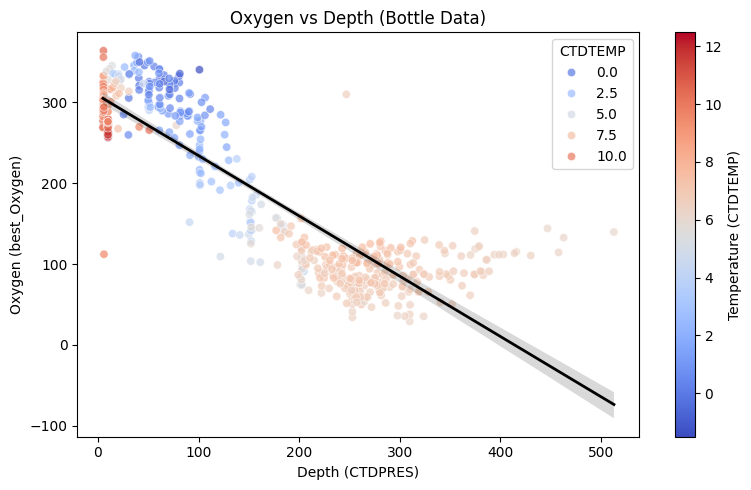

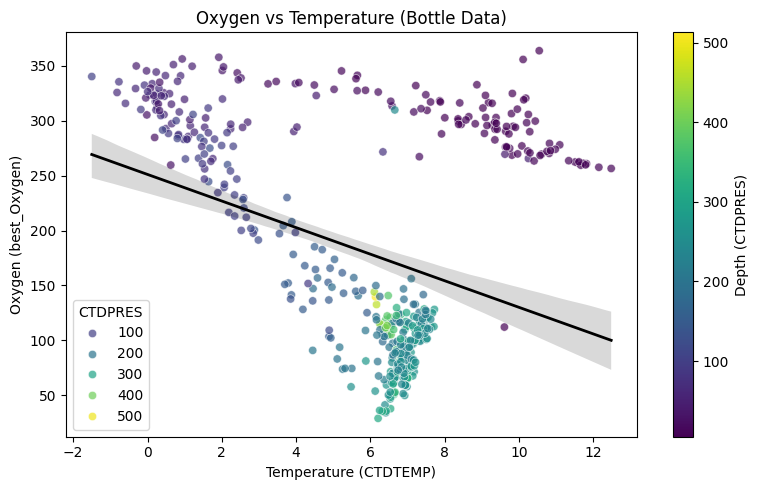

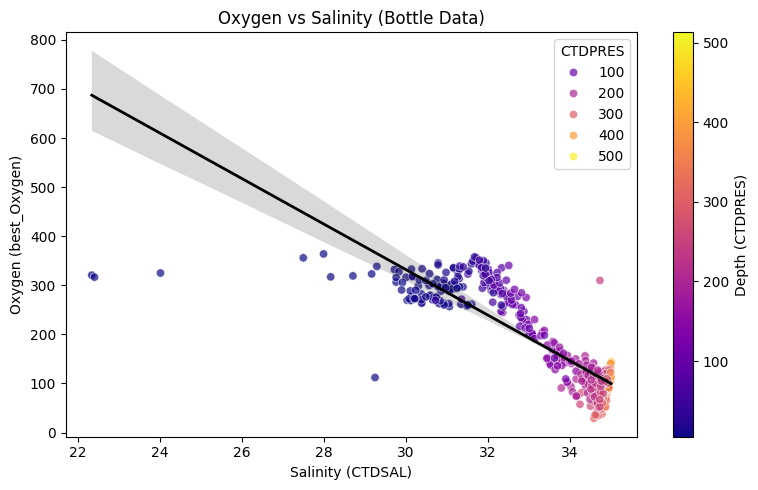

C:\Users\7PSYCHOPATH\AppData\Local\Temp\ipykernel_20940\3443532511.py:57: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\7PSYCHOPATH\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


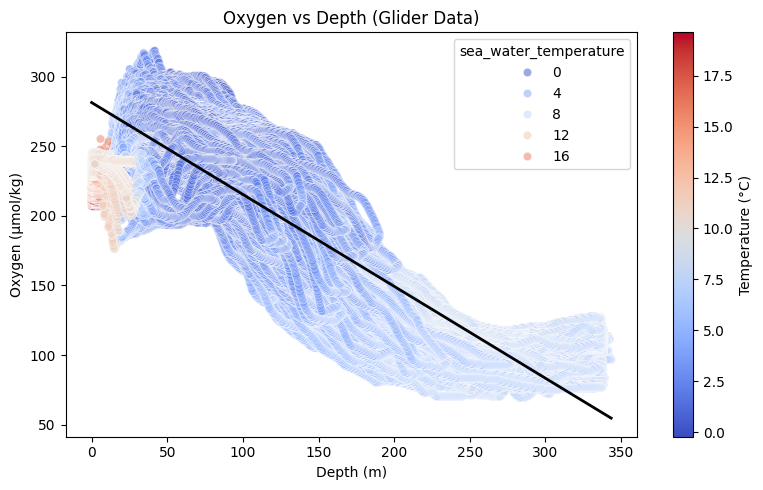

C:\Users\7PSYCHOPATH\AppData\Local\Temp\ipykernel_20940\3443532511.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\7PSYCHOPATH\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


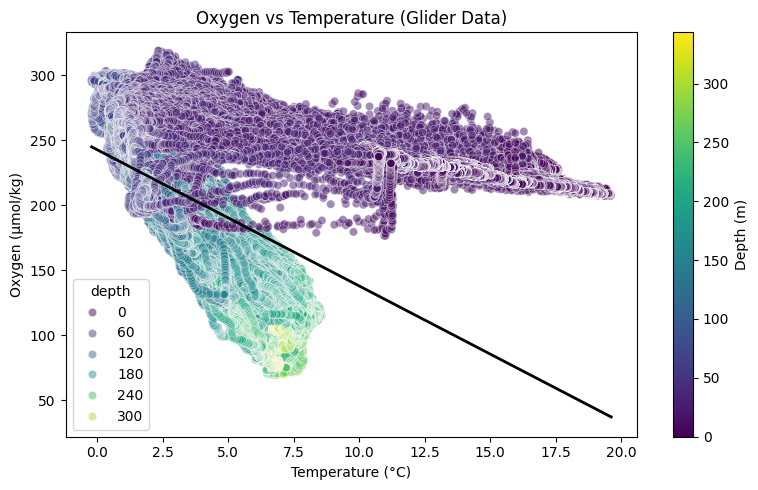

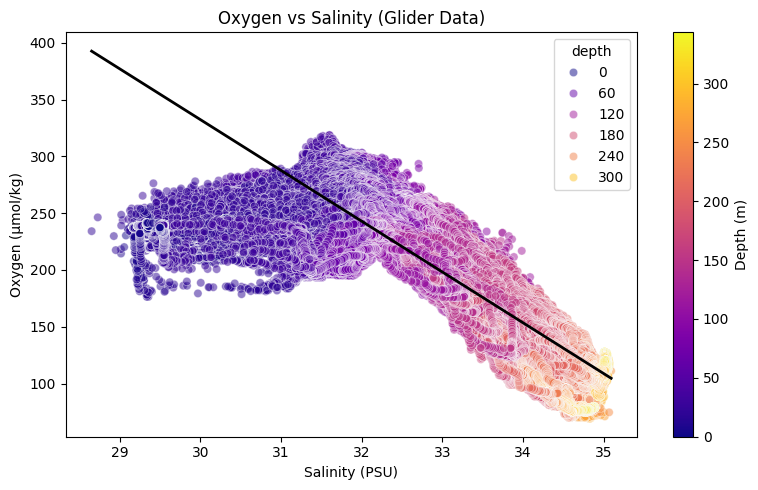

In [8]:
# Bottle Data
# Oxygen vs Depth (hue = Temperature)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df1, x="CTDPRES", y="best_Oxygen", hue="CTDTEMP", palette="coolwarm", alpha=0.7, ax=ax)
sns.regplot(data=df1, x="CTDPRES", y="best_Oxygen", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Depth (Bottle Data)")
ax.set_xlabel("Depth (CTDPRES)")
ax.set_ylabel("Oxygen (best_Oxygen)")
norm = plt.Normalize(df1["CTDTEMP"].min(), df1["CTDTEMP"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Temperature (CTDTEMP)")
plt.tight_layout()
plt.show()

# Oxygen vs Temperature (hue = Depth)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df1, x="CTDTEMP", y="best_Oxygen", hue="CTDPRES", palette="viridis", alpha=0.7, ax=ax)
sns.regplot(data=df1, x="CTDTEMP", y="best_Oxygen", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Temperature (Bottle Data)")
ax.set_xlabel("Temperature (CTDTEMP)")
ax.set_ylabel("Oxygen (best_Oxygen)")
norm = plt.Normalize(df1["CTDPRES"].min(), df1["CTDPRES"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Depth (CTDPRES)")
plt.tight_layout()
plt.show()

# Oxygen vs Salinity (hue = Depth)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df1, x="CTDSAL", y="best_Oxygen", hue="CTDPRES", palette="plasma", alpha=0.7, ax=ax)
sns.regplot(data=df1, x="CTDSAL", y="best_Oxygen", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Salinity (Bottle Data)")
ax.set_xlabel("Salinity (CTDSAL)")
ax.set_ylabel("Oxygen (best_Oxygen)")
norm = plt.Normalize(df1["CTDPRES"].min(), df1["CTDPRES"].max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Depth (CTDPRES)")
plt.tight_layout()
plt.show()


# Glider Data
# Oxygen vs Depth (hue = Temperature)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df2, x="depth", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", hue="sea_water_temperature", palette="coolwarm", alpha=0.5, ax=ax)
sns.regplot(data=df2, x="depth", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Depth (Glider Data)")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Oxygen (µmol/kg)")
norm = plt.Normalize(df2["sea_water_temperature"].min(), df2["sea_water_temperature"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Temperature (°C)")
plt.tight_layout()
plt.show()

# Oxygen vs Temperature (hue = Depth)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df2, x="sea_water_temperature", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", hue="depth", palette="viridis", alpha=0.5, ax=ax)
sns.regplot(data=df2, x="sea_water_temperature", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Temperature (Glider Data)")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Oxygen (µmol/kg)")
norm = plt.Normalize(df2["depth"].min(), df2["depth"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Depth (m)")
plt.tight_layout()
plt.show()

# Oxygen vs Salinity (hue = Depth)
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df2, x="sea_water_practical_salinity", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", hue="depth", palette="plasma", alpha=0.5, ax=ax)
sns.regplot(data=df2, x="sea_water_practical_salinity", y="micromoles_of_oxygen_per_unit_mass_in_sea_water", scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
ax.set_title("Oxygen vs Salinity (Glider Data)")
ax.set_xlabel("Salinity (PSU)")
ax.set_ylabel("Oxygen (µmol/kg)")
norm = plt.Normalize(df2["depth"].min(), df2["depth"].max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Depth (m)")
plt.tight_layout()
plt.show()

Findings:
- **Oxygen and Depth:** All six graphs show that oxygen levels decrease as depth increases. This matches with the expectation that oxygen levels drop with depth due to reduced light penetration and lower photosynthesis.  
- **Oxygen and Temprature:** The graphs show that warmer water generally has higher oxygen levels, while colder water has lower oxygen levels. This matches with the expectation that temperature influences oxygen solubility in water, with warmer water often holding more dissolved oxygen in surface layers. 
- **Oxygen and Salinity:** The graphs show that lower salinity water tends to have higher oxygen levels, while higher salinity water has lower oxygen levels. This matches with the expectation that salinity affects water density and oxygen availability, as saltier water is often denser and found at greater depths with less oxygen.  
- **Bottle vs Glider Data:** Both the bottle and glider data show similar trends in the relationships between oxygen levels, depth, temperature, and salinity. This consistency across different data collection methods suggests that these patterns are reliable and reflect real ocean conditions.

In [9]:
# correlations
correlation = merged_df[["best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water", "CTDTEMP", "CTDSAL"]].corr()
print("Correlation:\n", correlation)
# summary statistics
print("Summary Statistics:\n", merged_df[["best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water", "CTDTEMP", "CTDSAL"]].describe())

Correlation:
                                                  best_Oxygen  \
best_Oxygen                                         1.000000   
micromoles_of_oxygen_per_unit_mass_in_sea_water     0.025101   
CTDTEMP                                            -0.376111   
CTDSAL                                             -0.898999   

                                                 micromoles_of_oxygen_per_unit_mass_in_sea_water  \
best_Oxygen                                                                             0.025101   
micromoles_of_oxygen_per_unit_mass_in_sea_water                                         1.000000   
CTDTEMP                                                                                -0.036559   
CTDSAL                                                                                  0.011286   

                                                  CTDTEMP    CTDSAL  
best_Oxygen                                     -0.376111 -0.898999  
micromoles_of_oxygen_per

The correlation matrix shows how strong and what direction the relationships are between variables:

- **Oxygen Concentration (best_Oxygen) & Temperature (CTDTEMP):** The correlation is -0.376, which's a moderate negative relationship. Meaning, as temperature goes up, oxygen concentration tends to go down.

- **Oxygen Concentration (best_Oxygen) & Salinity (CTDSAL):** he correlation is -0.899, a strong negative relationship. This means that when salinity increases, oxygen concentration drops a lot. This likely happens because higher salinity makes it harder for water to hold oxygen.

- **Oxygen Concentration (best_Oxygen) & Micromoles of Oxygen per Unit Mass:** The correlation is 0.025, which is almost nothing, showing there's barely any connection between these two.

- **Temperature (CTDTEMP) & Salinity (CTDSAL):** The correlation is 0.075, which is very weak and positive, meaning temperature and salinity don't really affect each other much.

- **Temperature (CTDTEMP) & Micromoles of Oxygen per Unit Mass:** The correlation is -0.037, a weak negative one, showing there's not much of a relationship here either.

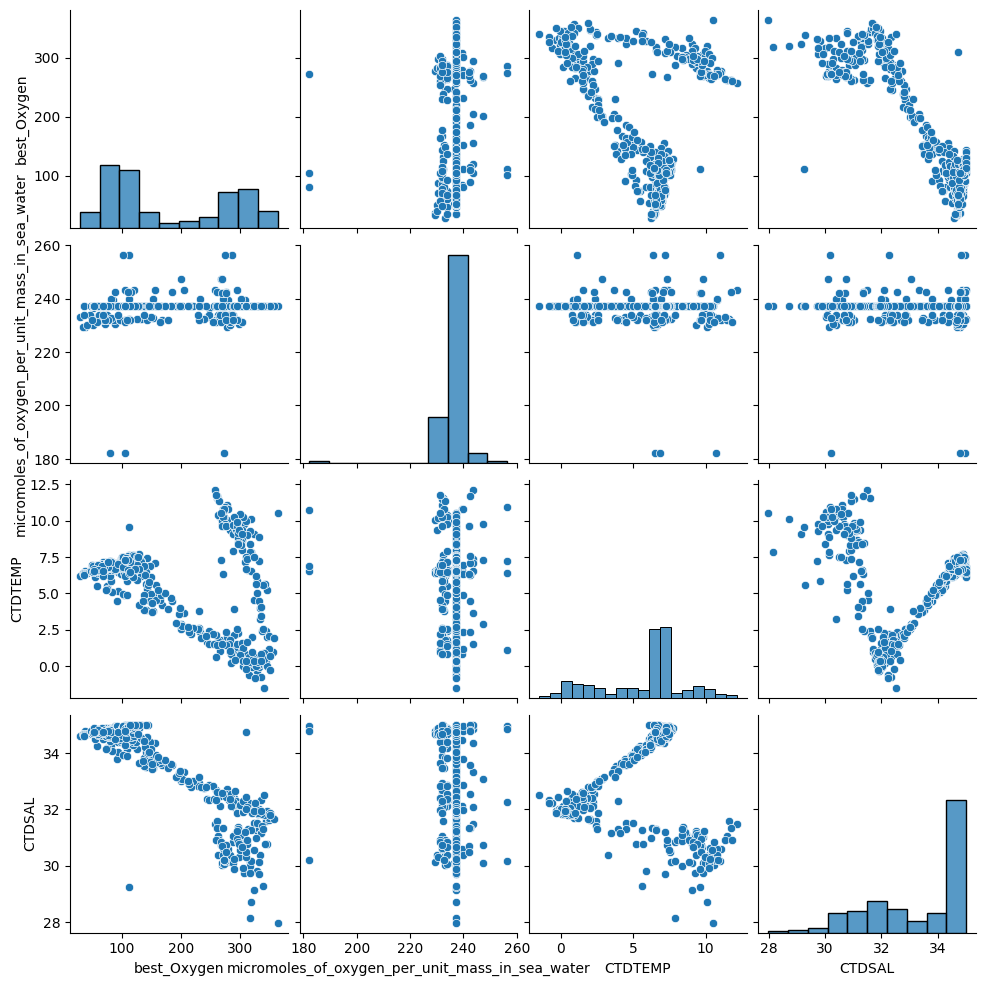

In [10]:
# pairplots
sns.pairplot(merged_df, vars=["best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water", "CTDTEMP", "CTDSAL"])
plt.show()

The scatter plots shows how the variables relate to each other.

- **best_Oxygen vs. CTDTEMP:** There's a downward trend, which matches the negative correlation seen earlier.
- **best_Oxygen vs. CTDSAL:** A clear downward trend, which fits with the strong negative correlation we found.
- **CTDTEMP vs. CTDSAL:** There's no obvious pattern, which matches the very weak correlation between them.
- **Micromoles of Oxygen per Unit Mass:** This shows little to no connection with the other variables, just like the near-zero correlations.

## Time Series Analysis

In [11]:
print("First few rows of time series data:\n", merged_df[["time", "best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water"]].head())
print("\nDescriptive Statistics:\n", merged_df[["best_Oxygen", "micromoles_of_oxygen_per_unit_mass_in_sea_water"]].describe())

First few rows of time series data:
                  time  best_Oxygen  \
0 2021-10-22 21:07:00    28.908497   
1 2021-10-22 21:07:00    57.633972   
2 2021-10-22 21:07:00    90.840147   
3 2021-10-22 21:07:00   244.645609   
4 2021-10-22 21:07:00   265.664677   

   micromoles_of_oxygen_per_unit_mass_in_sea_water  
0                                       232.981556  
1                                       232.981556  
2                                       232.981556  
3                                       232.981556  
4                                       232.981556  

Descriptive Statistics:
        best_Oxygen  micromoles_of_oxygen_per_unit_mass_in_sea_water
count   481.000000                                       481.000000
mean    178.553107                                       236.533955
std     102.353648                                         5.263891
min      28.908497                                       182.273593
25%      87.624932                                

- best_Oxygen values have a much wider range, going from 28.91 to 363.90, while the micromoles_of_oxygen_per_unit_mass_in_sea_water stays between 182.27 and 256.42.

- The average best_Oxygen value is 178.55, which is lower than the average Sensor Oxygen value of 236.53. This shows there might be a difference in how the two measurements were taken or a possible calibration issue.

- The micromoles_of_oxygen_per_unit_mass_in_sea_water has a small standard deviation of 5.26, meaning it stays pretty consistent over time.

- On the other hand, best_Oxygen has a much higher standard deviation of 102.35, showing it fluctuates a lot more.

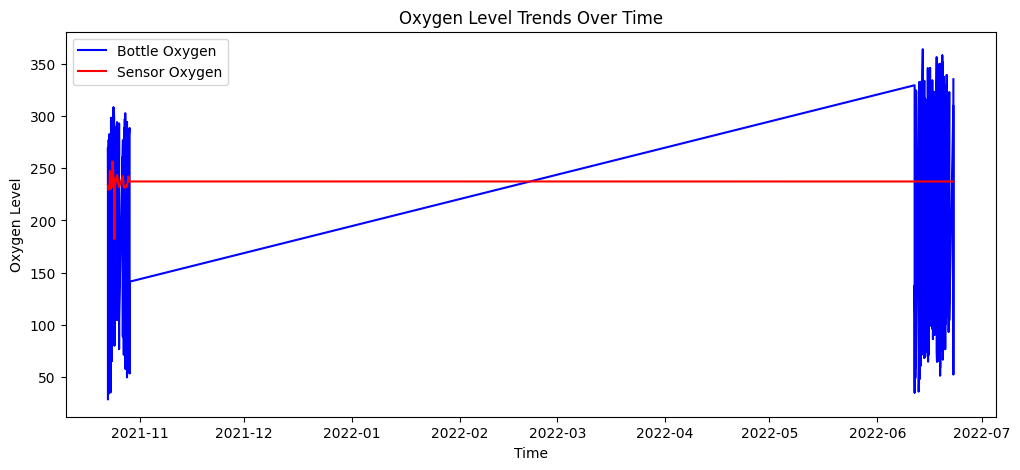

In [12]:
# Time series of oxygen levels
plt.figure(figsize=(12, 5))
plt.plot(merged_df["time"], merged_df["best_Oxygen"], label="Bottle Oxygen", color="blue")
plt.plot(merged_df["time"], merged_df["micromoles_of_oxygen_per_unit_mass_in_sea_water"], label="Sensor Oxygen", color="red")
plt.xlabel("Time")
plt.ylabel("Oxygen Level")
plt.title("Oxygen Level Trends Over Time")
plt.legend()
plt.show()

- The blue line, which represents best_Oxygen, shows a lot of ups and downs over time, indicating it changes quite a bit.

- The red line, representing micromoles_of_oxygen_per_unit_mass_in_sea_water, stays mostly steady, suggesting it doesn’t change much over the period observed.

- There is a sharp increase in best_Oxygen from around 2021-11 to 2022-06.

# Spatial Oxygen Distribution

In [13]:
print("First few rows of spatial data:\n", merged_df[["Longitude", "Latitude", "best_Oxygen"]].head())
print("\nDescriptive Statistics:\n", merged_df[["best_Oxygen"]].describe())

First few rows of spatial data:
    Longitude   Latitude  best_Oxygen
0   -67.2775  49.101389    28.908497
1   -67.2775  49.101389    57.633972
2   -67.2775  49.101389    90.840147
3   -67.2775  49.101389   244.645609
4   -67.2775  49.101389   265.664677

Descriptive Statistics:
        best_Oxygen
count   481.000000
mean    178.553107
std     102.353648
min      28.908497
25%      87.624932
50%     125.448426
75%     289.252788
max     363.904648


- The oxygen concentration values range from 28.91 to 363.90 with a mean of 178.55.

- There's a lot of variation, shown by the standard deviation of 102.35.

- The median (50th percentile) value is 125.45, which is lower than the mean. This suggests the distribution is right-skewed, meaning a few high values are pulling the average up.

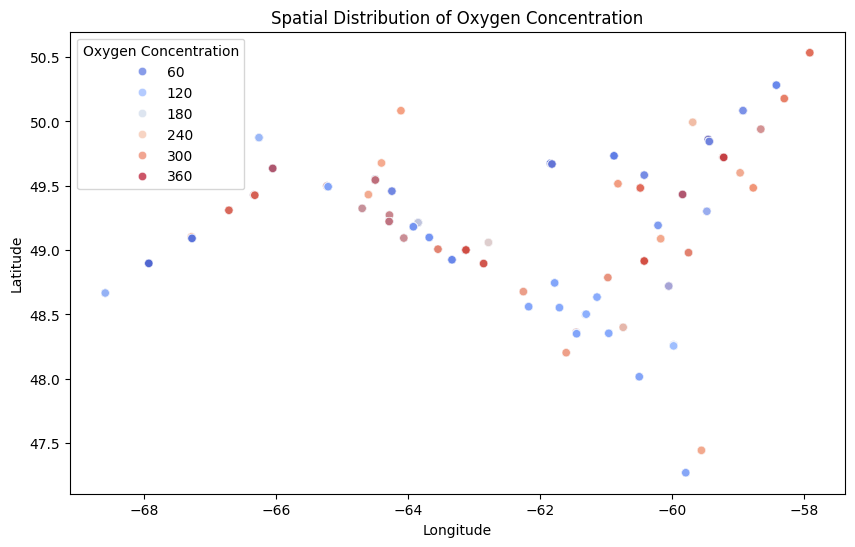

In [14]:
#scatter plot for spatial distribution of oxygen concentration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="Longitude", y="Latitude", hue="best_Oxygen", palette="coolwarm", alpha=0.7)
plt.legend(title="Oxygen Concentration")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Oxygen Concentration")
plt.show()

- The plot shows different oxygen concentrations across longitude and latitude.

- The color gradient shows oxygen levels, with darker red showing higher concentration and darker blue showing lower concentration.

- There seems to be some clustering of oxygen levels around certain latitudes, which could show spatial trends.

                                                 best_Oxygen  \
best_Oxygen                                         1.000000   
micromoles_of_oxygen_per_unit_mass_in_sea_water     0.025101   
CTDTEMP                                            -0.376111   
CTDSAL                                             -0.898999   

                                                 micromoles_of_oxygen_per_unit_mass_in_sea_water  \
best_Oxygen                                                                             0.025101   
micromoles_of_oxygen_per_unit_mass_in_sea_water                                         1.000000   
CTDTEMP                                                                                -0.036559   
CTDSAL                                                                                  0.011286   

                                                  CTDTEMP    CTDSAL  
best_Oxygen                                     -0.376111 -0.898999  
micromoles_of_oxygen_per_unit_mass_in_

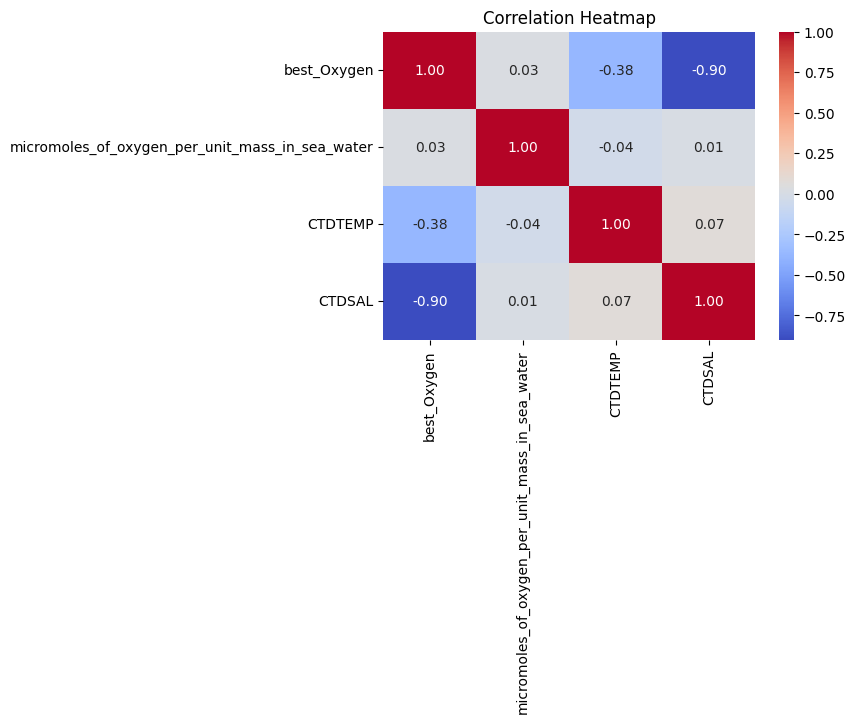

In [15]:
# Correaltion matrix
print(correlation)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


- best_Oxygen has a strong negative correlation with CTDSAL (-0.90), meaning that as salinity goes up, oxygen concentration drops a lot.

- best_Oxygen also shows a moderate negative correlation with temperature (CTDTEMP) of -0.38, showing that cooler temperatures are linked to higher oxygen levels.

- The correlation between best_Oxygen and micromoles_of_oxygen_per_unit_mass_in_sea_water is very weak (0.025), which means these two might be measuring different aspects of oxygen content.

---

## Train, Test Split

In [16]:
# Selecting features and target
features = ["CTDTEMP", "CTDSAL", "depth"]
target = "micromoles_of_oxygen_per_unit_mass_in_sea_water"

#filling missing values in features
merged_df[features] = merged_df[features].fillna(merged_df[features].mean())

#filling missing values in the target
merged_df[target] = SimpleImputer(strategy='mean').fit_transform(merged_df[[target]])

# X=features and y=target variable
X = merged_df[features]
y = merged_df[target]


X_scaled = StandardScaler().fit_transform(X)

# train test split (80, 20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (384, 3), Test set: (97, 3)


## Random Forest Regression

In [17]:
#training Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#predict and evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest R² Score: {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")


Random Forest R² Score: 0.8497
Mean Absolute Error (MAE): 0.48


Results:
- R² Score (Test): Good fit
- MAE (Test): Low error

In [18]:
#comparing model with Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
print(f"Linear Regression R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")

Linear Regression R² Score: -0.6235
Linear Regression MAE: 1.82


Results:
- R² Score: Very poor fit, meaning it's performing worse than just predicting the average of the target variable.
- MAE: High error
- Linear Regression didn't perform well, probably because the data isn't linear and needs a different approach.

In [25]:
# cross validation
cv_scores = cross_val_score(rf_model, X, y)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")

Cross-validation scores: [-0.05866755  0.20723296  0.          0.          0.        ]
Mean CV Score: 0.0297


Results:
- Cross-Validation Score (Mean): Poor, likely due to overfitting or issues with the way the data is distributed.

In [20]:
#hyperparameter tuning
#defining the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

#setting up GridSearchCV and fitting the model
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score:  0.8471619907476603


Results:
- Best cross-validation score: Very good, showing that the model is performing much better than the baseline model.

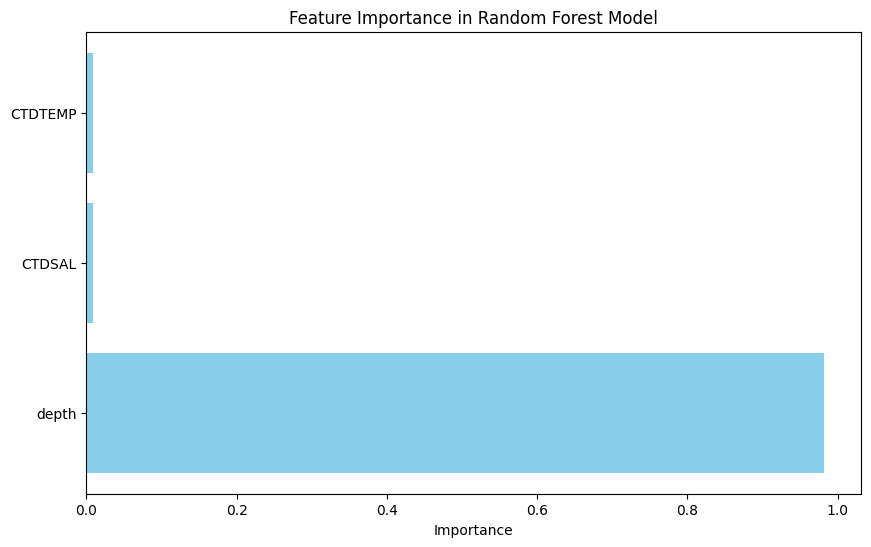

   Feature  Importance
2    depth    0.982259
1   CTDSAL    0.009071
0  CTDTEMP    0.008670


In [21]:
#fitting rf model and getting feature imprtances
rf_model.fit(X_train, y_train)
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


print(feature_importance_df)

The depth feature seems to have the biggest impact on oxygen concentration, likely because of factors like:
- Less sunlight reaching deeper waters, which affects photosynthesis.
- Changes in temperature and pressure as you go deeper.
- Less mixing of water layers, leading to different oxygen levels at various depths.

Salinity and temperature have a smaller, but still noticeable, effect, probably because they influence how much oxygen can dissolve in the water and how it's spread around.

In [22]:
#fitting best rf model
best_rf_model = RandomForestRegressor(n_estimators=50, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best = best_rf_model.predict(X_test)
print(f"Best Model R² Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"Best Model MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")


Best Model R² Score: 0.8222
Best Model MAE: 0.5202


Results:
- R² Score: Indicates a good fit to the data
- Mean Absolute Error (MAE): Low error

---

- comparing the actual vs. predicted values and assess the performance of tuned Random Forest model

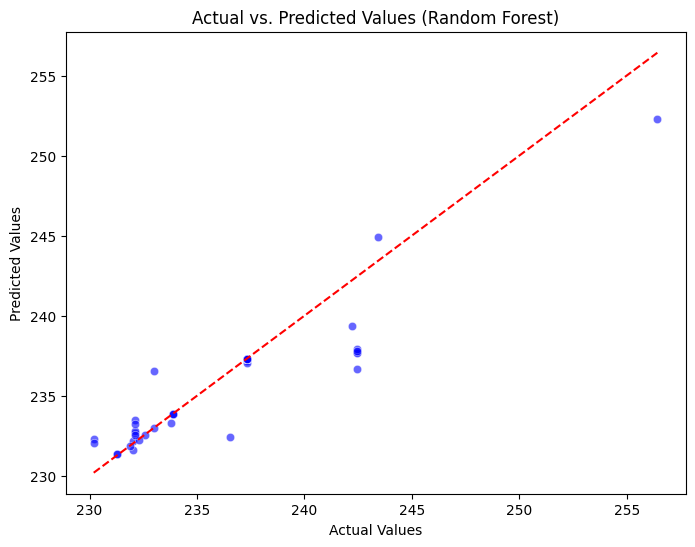

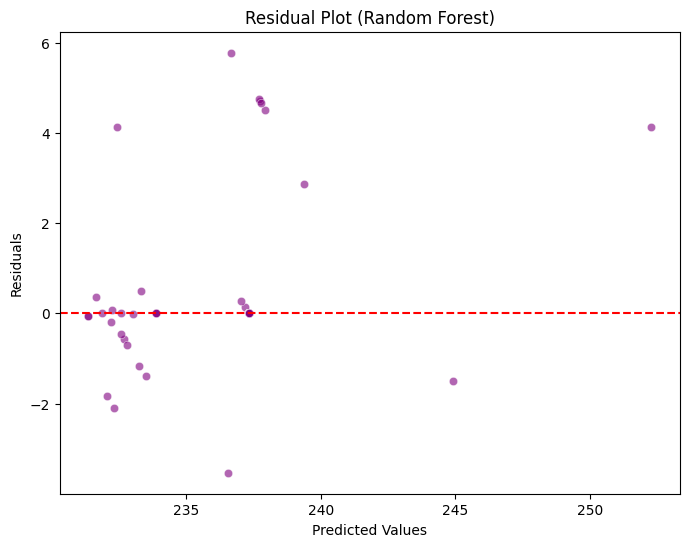

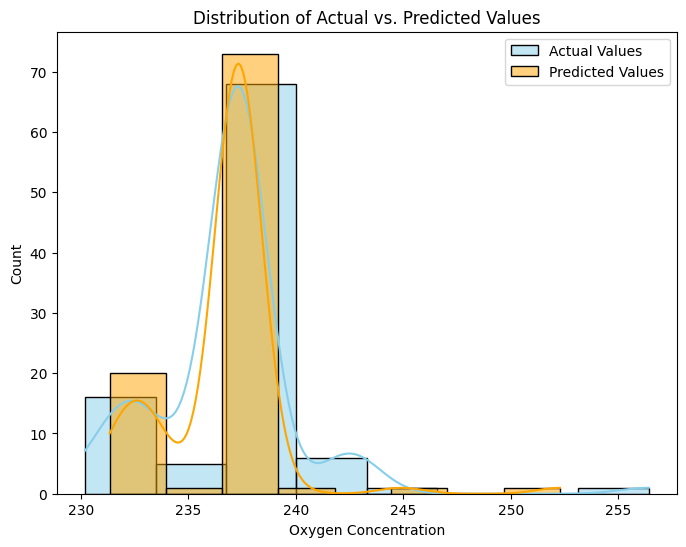

In [23]:
#scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

#residual plot
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_best, y=residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

#distribution plot
plt.figure(figsize=(8, 6))
sns.histplot(y_test, label='Actual Values', color='skyblue', kde=True)
sns.histplot(y_pred_best, label='Predicted Values', color='orange', kde=True)
plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('Oxygen Concentration')
plt.legend()
plt.show()


Results:
- The model is performing well, as shown in the first plot where most points are close to the diagonal.

- The residual plot indicates that while most errors are small, there are some noticeable deviations, which could be due to underfitting or limitations in the model’s structure.

- The distribution plot shows that the predictions generally match the actual values, but there are some differences, especially in extreme cases.